# 2024 Assignment for Text Mining Course at GSOM Group 7

### Team Members
- *Bolliger Zambetti Francesco*
- *Cappello Giorgio*
- *Milosevic Ksenija*
- *Ratti Andrea Enrico*

### Industry Focus
We decided to focus on the *Defence & Aerospace* sector due to its potential high sensitivity to news information that could impact their stock prices. We selected 9 companies listed on exchanges, specifically:

- *Northrop Grumman* - United States
- *Lockheed Martin* - United States
- *General Dynamics* - United States
- *Elbit Systems* - Israel
- *Embraer* - Brazil
- *Dassault Aviation* - France
- *BAE Systems* - United Kingdom
- *Safran* - France
- *Thales Group* - France

## Process Flow
0. *Packages installation and import*
1. *Gather News Data, Build a DataFrame & Clean News Headlines*
2. *Sentiment Analysis using TextBlob & Vader*
3. *Source Stock Prices & Create Labels for Price and Volume change*
4. *Clean, Merge, and define a handmade headline classifier*
5. *Training of the classifier and visualization*

### NOTAMs

Although functional, the news gathering code is painfully slow. To check whether it works or not (spoiler ahead: it does) we suggest modifying names, tickers and start_date to be a 1 day extraction on 1 name/ticker pair; ça va sans dire that the name and the ticker should refer to the same stock.

## Packages installation and import

In [1]:
!pip install scikit-learn
!pip install imblearn
!pip install tabulate
!pip install keras
!pip install tensorflow
!pip install setuptools
!pip install matplotlib
!pip install seaborn
!pip install yfinance
!pip install pandas
!pip install vaderSentiment
!pip install shap
!pip install openpyxl
!pip install urllib

from sklearn.metrics import classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import confusion_matrix
from datetime import datetime, timedelta

import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import bs4 as bs
import re
import time



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Gather News Data, Build a DataFrame & Clean News Headlines

### Overview

With this script we gather news headlines for specified companies, clean the text, and analyze the sentiment using two different sentiment analysis tools: TextBlob and VADER.

To start, the script defines a function clean(text) to preprocess the news headlines. This function removes punctuation (excluding numbers and percent symbols), converts the text to lowercase, and removes extra spaces to ensure consistency in the text data.

We then use urllib.request and BeautifulSoup to fetch news headlines. The get_news_headlines(name, ticker) function retrieves news articles related to a specific company by constructing a URL for Google News RSS feeds. The code then makes requests to fetch the news data up to the selected date, waits for 5 seconds between each request to avoid IP bans, and parses the XML response to extract headlines and publication dates. The headlines are cleaned using the previously defined clean(text) function, and the data is stored in a DataFrame with columns for Date, Headline, and Stock ticker.

The list of company names (names) and their corresponding stock tickers (tickers) are defined, as well as the earliest date. The script initializes an empty DataFrame all_news_df and iterates over the list of company names, calling get_news_headlines for each company and concatenating the results into all_news_df.

As per the README attached, this operation requires a long time. For this reason we are then loading the NewsDataExtraction.xslx containing news headlines up to Oct. 1st, 2023. 

In [2]:
# Function to clean text
def clean(text):
    text = re.sub(r'[^\w\s%]', '', text)        # Remove punctuation except numbers and percent symbols
    text = text.lower()                         # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces
    return text

In [3]:
# News scraping function
def get_news_headlines(name, ticker, start_date):
    headlines = []
    dates = []
    stock = []
    ticker = re.match(r'^[^.]+', ticker)[0]
    current_date = start_date
    while current_date <= datetime.now():
        url = f'https://news.google.com/rss/search?q={name}+after:{current_date.strftime("%Y-%m-%d")}&hl=en-US&gl=US&ceid=US:en'
        print(f"Fetching news from: {url}")  # Debugging output
        time.sleep(5)  # Wait 5 seconds between each request to avoid IP bans
        try:
            doc = urllib.request.urlopen(url).read()
            parsed_doc = bs.BeautifulSoup(doc, 'xml')  # Use XML parser
            for item in parsed_doc.find_all('item'):
                headline = clean(item.title.text)
                if headline not in headlines:  # Ensure the headline is unique
                    headlines.append(headline)
                    dates.append(item.pubDate.text)
                    stock.append(ticker)
        except Exception as e:
            print(f"Error fetching news: {e}")
        current_date += timedelta(days=1)  # Increment the date
    return pd.DataFrame({'Date': dates, 'Headline': headlines, 'Stock': stock})

In [4]:
# Inizialising names and tickers for the chosen industry
names = ['Northrop+Grumman','Lockheed+Martin','General+Dynamics','Elbit+Systems','Embraer','Dassault+Aviation','BAESY','Safran','Thales']
tickers = ['NOC','LMT','GD','ESLT','ERJ','DUAVF', 'BAESY', 'SAF.PA', 'HO.PA']

# Choosing the starting date
all_news_df = pd.DataFrame()
start_date = datetime(2023, 10, 1)

# News scraping
for name, ticker in zip(names, tickers):
    news_df = get_news_headlines(name, ticker, start_date)
    all_news_df = pd.concat([all_news_df, news_df], ignore_index=True)

Fetching news from: https://news.google.com/rss/search?q=Northrop+Grumman+after:2023-10-01&hl=en-US&gl=US&ceid=US:en
Fetching news from: https://news.google.com/rss/search?q=Northrop+Grumman+after:2023-10-02&hl=en-US&gl=US&ceid=US:en


KeyboardInterrupt: 

### News data loading

Please insert the file path of the NewsDataExtraction.xslx provided with the code in place of the three dots below


In [5]:
all_news_df=pd.read_excel(r"...")  # please insert the file path of the NewsDataExtraction.xslx provided with the code 
all_news_df

,Date,Headline,Stock
0,"Fri, 01 Mar 2024 08:00:00 GMT",elbit subsidiary to supply hostile fire detect...,ESLT
1,"Fri, 02 Feb 2024 08:00:00 GMT",fort worths elbit systems of america names new...,ESLT
2,"Fri, 03 May 2024 07:00:00 GMT",darpa selects northrop grumman umbra for phase...,NOC
3,"Fri, 03 May 2024 07:00:00 GMT",grand forks school district and northrop grumm...,NOC
4,"Fri, 03 May 2024 07:00:00 GMT",international assets investment management llc...,ESLT
...,...,...,...
2012,"Fri, 03 May 2024 07:00:00 GMT",execujet mro services opens new business aviat...,DUAVF
2013,"Fri, 03 May 2024 07:00:00 GMT",joe bogosian appointed president ceo of safran...,SAF
2014,"Fri, 03 May 2024 07:00:00 GMT",safran signs support contract with air rescue ...,SAF
2015,"Fri, 02 Feb 2024 08:00:00 GMT",adp and dassault push to decarbonize le bourge...,DUAVF


## Sentiment Analysis using TextBlob & Vader

### Overview

For sentiment analysis, we decided to employ two different tools: TextBlob and VADER. The get_sentiment_textblob(text) function uses TextBlob to calculate the sentiment polarity of a given text, while the get_sentiment_VADER(text) function uses VADER to obtain a compound sentiment score. These functions are applied to the 'Headline' column of all_news_df to create two new columns: 'Sentiment textblob' and 'Sentiment Vader'. We made this choice in order to compare two different tools and check for any misalignment among the two. 

For merging purposes we also convert the 'Date' column in all_news_df to a datetime format, ensuring that dates are consistent and correctly parsed.

Two visualization functions are defined to analyze the sentiment data. The plot_sentiment(news_df) function plots the distribution of sentiment scores for both TextBlob and VADER using histograms. The plot_average_sentiment_per_stock(news_df) function calculates the average sentiment score for each stock and plots the results using bar plots, allowing comparison of average sentiment across different stocks. Here we have some interesting results, showing some inconsistencies but otherwise general agreement between the two. 

Finally, the script calls these visualization functions to display the sentiment distribution and average sentiment per stock. We then drops the 'Sentiment Vader' column from all_news_df: moving forward we will only use the textblob sentiment.


In [6]:
# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_textblob(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def get_sentiment_VADER(text):
    analysis = analyzer.polarity_scores(text)
    return analysis['compound']


In [7]:
# Dates regularization and sentiment analysis using Textblob and Vader
all_news_df['Date'] = pd.to_datetime(all_news_df['Date'], format='%a, %d %b %Y %H:%M:%S %Z').dt.date
all_news_df['Sentiment textblob'] = all_news_df['Headline'].apply(get_sentiment_textblob)
all_news_df['Sentiment Vader'] = all_news_df['Headline'].apply(get_sentiment_VADER)

In [8]:
# Data visualization
def plot_sentiment(news_df):
    plt.figure(figsize=(12, 6))
    sns.histplot(news_df['Sentiment textblob'], kde=True, color='blue', label='TextBlob')
    sns.histplot(news_df['Sentiment Vader'], kde=True, color='green', label='VADER')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequence')
    plt.legend()
    plt.show()

def plot_average_sentiment_per_stock(news_df):
    avg_sentiment = news_df.groupby('Stock')[['Sentiment textblob', 'Sentiment Vader']].mean().reset_index()
    avg_sentiment = pd.melt(avg_sentiment, id_vars=['Stock'], value_vars=['Sentiment textblob', 'Sentiment Vader'], 
                            var_name='Sentiment Type', value_name='Sentiment Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg_sentiment, x='Stock', y='Sentiment Score', hue='Sentiment Type')
    plt.title('Sentimento Medio per Azione')
    plt.xlabel('Azione')
    plt.ylabel('Sentiment Medio')
    plt.legend()
    plt.show()



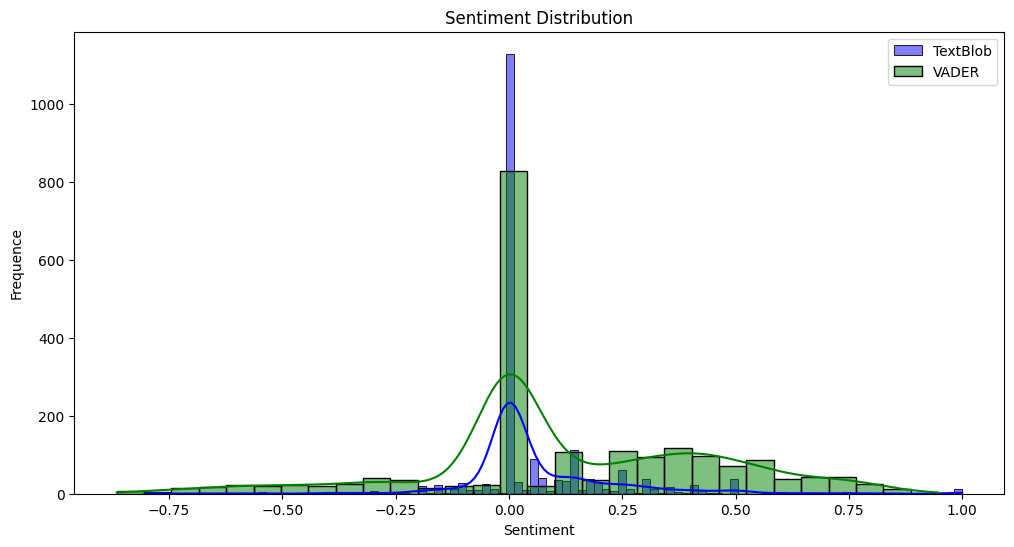

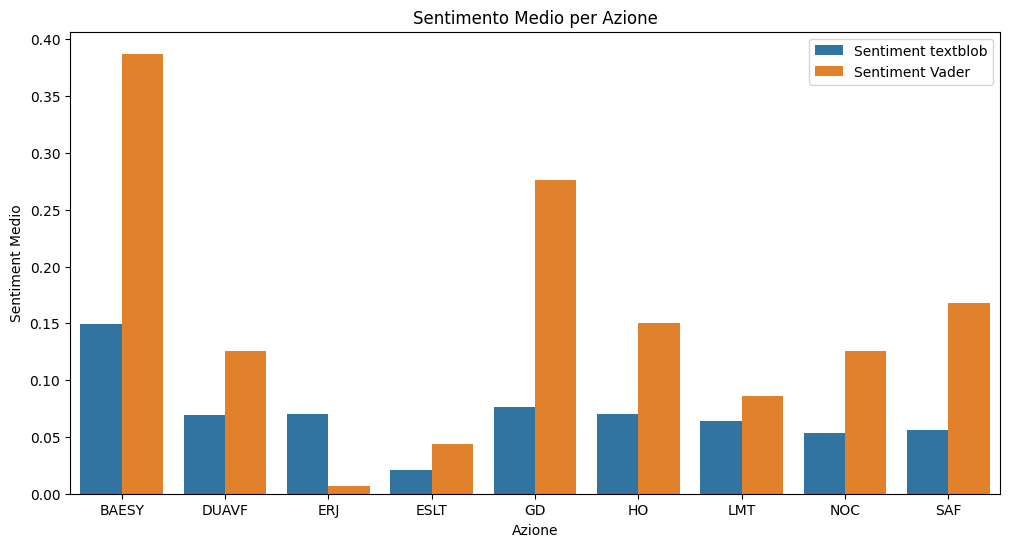

In [9]:
# Textblob and Vader comparison
plot_sentiment(all_news_df)
plot_average_sentiment_per_stock(all_news_df)

In [10]:
# Dropping the Vader sentiment
all_news_df=all_news_df.drop(columns=['Sentiment Vader'])
all_news_df

,Date,Headline,Stock,Sentiment textblob
0,2024-03-01,elbit subsidiary to supply hostile fire detect...,ESLT,0.000000
1,2024-02-02,fort worths elbit systems of america names new...,ESLT,0.136364
2,2024-05-03,darpa selects northrop grumman umbra for phase...,NOC,0.000000
3,2024-05-03,grand forks school district and northrop grumm...,NOC,0.500000
4,2024-05-03,international assets investment management llc...,ESLT,0.068182
...,...,...,...,...
2012,2024-05-03,execujet mro services opens new business aviat...,DUAVF,0.136364
2013,2024-05-03,joe bogosian appointed president ceo of safran...,SAF,0.000000
2014,2024-05-03,safran signs support contract with air rescue ...,SAF,0.000000
2015,2024-02-02,adp and dassault push to decarbonize le bourge...,DUAVF,0.000000


## Source Stock Prices & Create Labels for Price and Volume change 

### Overview
This script is designed to retrieve and process financial data for the chosen tickers. It performs several tasks including fetching historical data, calculating daily changes, labeling price and volume changes.

To begin, the script defines a function financial_data(ticker) that takes a stock ticker symbol as input. Inside this function, the yf.Ticker method from the yfinance library fetches the ticker's data. The time.sleep(5) function is included to wait for 5 seconds between requests to avoid IP address bans due to sending frequent requests.

The historical data is fetched using the history method, specifying a date range from January 1, 2019, to May 31, 2024. The index of the DataFrame is then reset and the Date column is converted to just the date part to prepare for later merging.

Next, the script calculates the daily change in the closing price by using the diff() method on the Close column, storing the result in a new column called Change. It also creates a boolean column, Positive Change, which indicates whether the change in the closing price is positive.

To identify substantial changes in the stock price, a threshold of 0.01 is used. A new column, Substantial Change, is created to indicate whether the absolute change in the closing price divided by the closing price exceeds this threshold. 

We then define our first hyperparameter, Price_label, using np.select to classify the price changes in different classes based on the substantial change and the direction of the change.

Similarly, we calculate changes in trading volume. A threshold of 0.33 is applied, and the Volume_label column is created to label the trading volume as 'High_volume' or 'Normal_volume'.

Rows with missing values in the Change column are dropped to ensure data consistency.

The script also extracts the stock symbol from the ticker and assigns it to a new column called Stock using a regular expression match.

The financial_data function returns the processed DataFrame for the given ticker.

The main part of the script initializes an empty DataFrame stock_data and iterates over our tickers. For each ticker, it calls the financial_data function and concatenates the returned DataFrame to stock_data.

Finally, the script prints the count of each label in the Substantial Change column, providing an overview of the data distribution.



In [15]:
def financial_data(ticker):
    tickerData = yf.Ticker(ticker)
    time.sleep(5) ## wait 5 seconds between each request.
    df = tickerData.history(start="2019-01-01", end="2024-05-31")
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].dt.date  
    
    # Definition of the Price label
    price_threshold = 0.01
    high_price_threshold = 0.03
    super_price_threshold = 0.05
    df['Change'] = df['Close'].diff()
    df['Price_label'] = np.select(
            [
                (abs(df['Change']) / df['Close'] > super_price_threshold) & (df['Change'] > 0),
                (abs(df['Change']) / df['Close'] > high_price_threshold) & (df['Change'] > 0),
                (abs(df['Change']) / df['Close'] > price_threshold) & (df['Change'] > 0),
                (abs(df['Change']) / df['Close'] > price_threshold) & (df['Change'] < 0),
                (abs(df['Change']) / df['Close'] > high_price_threshold) & (df['Change'] < 0),
                (abs(df['Change']) / df['Close'] > super_price_threshold) & (df['Change'] < 0)
            ],
            [
                'super positive',
                'very positive',
                'positive',
                'negative',
                'very negative',
                'super negative'
            ],
        default='no_change'
    )

    # Definition of the Volume label
    vol_threshold = 0.33
    df['Volume_label'] = np.select(
            [
                (((df['Volume'] - min(df['Volume'])) / (max(df['Volume']) - min(df['Volume'])))  > vol_threshold)
            ],
            [
                'High_volume',
            ],
            default='Normal_volume'
        )

    # Dropping NaNs
    df = df.dropna(subset=['Change'])

    # Matching
    df['Stock'] = re.match(r'^[^.]+', ticker)[0]

    return df


In [16]:
# Scraping of financial data
tickers = ['NOC','LMT','GD','ESLT','ERJ','DUAVF', 'BAESY', 'SAF.PA', 'HO.PA']
stock_data = pd.DataFrame()

# Building the dataframe
for ticker in tickers:
    stock_data = pd.concat([stock_data, financial_data(ticker)], ignore_index=True)

# Dropping unused columns
stock_data = stock_data.drop(columns=['Dividends'])
stock_data = stock_data.drop(columns=['Stock Splits'])

# Print to check
stock_data


,Date,Open,High,Low,Close,Volume,Change,Price_label,Volume_label,Stock
0,2019-01-03,223.816537,224.081705,217.900398,219.381714,1703900,-5.897842,negative,High_volume,NOC
1,2019-01-04,222.536394,226.724327,221.759167,226.678604,1127800,7.296890,very positive,Normal_volume,NOC
2,2019-01-07,226.404292,229.842414,224.035998,228.443390,1388500,1.764786,no_change,High_volume,NOC
3,2019-01-08,229.878992,231.698643,226.779192,229.476669,1082400,1.033279,no_change,Normal_volume,NOC
4,2019-01-09,229.430947,231.524907,228.123355,230.564789,727700,1.088120,no_change,Normal_volume,NOC
...,...,...,...,...,...,...,...,...,...,...
12296,2024-05-24,167.649994,167.750000,165.250000,166.199997,136865,-1.650009,no_change,Normal_volume,HO
12297,2024-05-27,166.199997,167.350006,165.500000,167.000000,59095,0.800003,no_change,Normal_volume,HO
12298,2024-05-28,167.600006,168.500000,163.899994,164.000000,298485,-3.000000,negative,Normal_volume,HO
12299,2024-05-29,163.500000,164.399994,162.199997,164.050003,157234,0.050003,no_change,Normal_volume,HO


In [17]:
# Label counter
print("Labels count:")
print(stock_data['Price_label'].value_counts())
print(stock_data['Volume_label'].value_counts())

Labels count:
Price_label
no_change         6842
negative          2585
positive          2254
very positive      392
super positive     228
Name: count, dtype: int64
Volume_label
Normal_volume    11827
High_volume        474
Name: count, dtype: int64


## Clean, Merge, and define a handmade headline classifier

### Overview

We then merge the news dataframe and the stocks dataframe to prepare for later, performing the final checks.

Here we define the headline classifier; in accordance with the Price_label, we assign a value to the headline and then modify said value in accordance with the Volume_label. The distribution of Sentiment_value we get is roughly the same as textblob and Vader, which is a positive feedback. 




In [18]:
# Merge data
merged_data = pd.merge(stock_data, all_news_df, on=['Stock','Date'], how='inner')
merged_data

,Date,Open,High,Low,Close,Volume,Change,Price_label,Volume_label,Stock,Headline,Sentiment textblob
0,2020-11-04,291.463017,304.870325,290.522814,296.765778,1684000,10.173035,very positive,High_volume,NOC,this unidentified plane flew over california t...,0.000
1,2023-08-07,430.562571,432.027695,425.881999,429.372772,1289300,-1.848633,no_change,High_volume,NOC,max q a rocket retirement and layoffs at plane...,0.000
2,2023-09-15,427.090821,430.330098,426.113122,428.108032,1033200,1.155457,no_change,Normal_volume,NOC,china sanctions northrop grumman lockheed mart...,0.000
3,2023-10-30,467.789213,469.102687,461.597038,462.861145,1032600,-4.335510,no_change,Normal_volume,NOC,northrop grumman selected to deliver nearly 40...,0.500
4,2023-11-10,455.819633,458.476238,452.649495,457.518280,758500,2.152924,no_change,Normal_volume,NOC,what you need to know about northrop grummans ...,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
1524,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,aircraft communication market getting back to ...,0.125
1525,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,thales enters app security market with 36b imp...,0.000
1526,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,elevate your iam strategy with thales at eic 2...,0.000
1527,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,europe seeks to emulate nasas revolutionary co...,0.000


In [19]:
# Empty headlines counter
print("Empty headlines:", merged_data['Headline'].isnull().sum())

# Labels counter
print("Labels count:")
print(merged_data['Price_label'].value_counts())
print(merged_data['Volume_label'].value_counts())

Empty headlines: 0
Labels count:
Price_label
no_change         855
negative          408
positive          213
very positive      36
super positive     17
Name: count, dtype: int64
Volume_label
Normal_volume    1472
High_volume        57
Name: count, dtype: int64


In [20]:
# Text classifier definition
price_label_classification = {
    'no_change': 0,
    'positive': 0.1,
    'very positive': 0.3,
    'super positive': 0.5,
    'negative': -0.1,
    'very negative': -0.3,
    'super negative': -0.5
}

# Apply the mapping to create a new column in the dataframe
merged_data['Sentiment value'] = merged_data['Price_label'].map(price_label_classification)

In [21]:
# Adjust the 'Sentiment value' column based on the 'Volume_label'
def adjust_sentiment_value(row):
    if row['Volume_label'] == 'High_volume':
        if row['Sentiment value'] > 0:
            return row['Sentiment value'] + 0.1
        elif row['Sentiment value'] < 0:
            return row['Sentiment value'] - 0.1
    return row['Sentiment value']


merged_data['Sentiment value'] = merged_data.apply(adjust_sentiment_value, axis=1)

In [22]:
# Merged data final shape to check health of the headline classifier
merged_data

,Date,Open,High,Low,Close,Volume,Change,Price_label,Volume_label,Stock,Headline,Sentiment textblob,Sentiment value
0,2020-11-04,291.463017,304.870325,290.522814,296.765778,1684000,10.173035,very positive,High_volume,NOC,this unidentified plane flew over california t...,0.000,0.4
1,2023-08-07,430.562571,432.027695,425.881999,429.372772,1289300,-1.848633,no_change,High_volume,NOC,max q a rocket retirement and layoffs at plane...,0.000,0.0
2,2023-09-15,427.090821,430.330098,426.113122,428.108032,1033200,1.155457,no_change,Normal_volume,NOC,china sanctions northrop grumman lockheed mart...,0.000,0.0
3,2023-10-30,467.789213,469.102687,461.597038,462.861145,1032600,-4.335510,no_change,Normal_volume,NOC,northrop grumman selected to deliver nearly 40...,0.500,0.0
4,2023-11-10,455.819633,458.476238,452.649495,457.518280,758500,2.152924,no_change,Normal_volume,NOC,what you need to know about northrop grummans ...,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,aircraft communication market getting back to ...,0.125,0.0
1525,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,thales enters app security market with 36b imp...,0.000,0.0
1526,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,elevate your iam strategy with thales at eic 2...,0.000,0.0
1527,2024-05-30,163.649994,165.399994,162.850006,164.300003,119329,0.250000,no_change,Normal_volume,HO,europe seeks to emulate nasas revolutionary co...,0.000,0.0


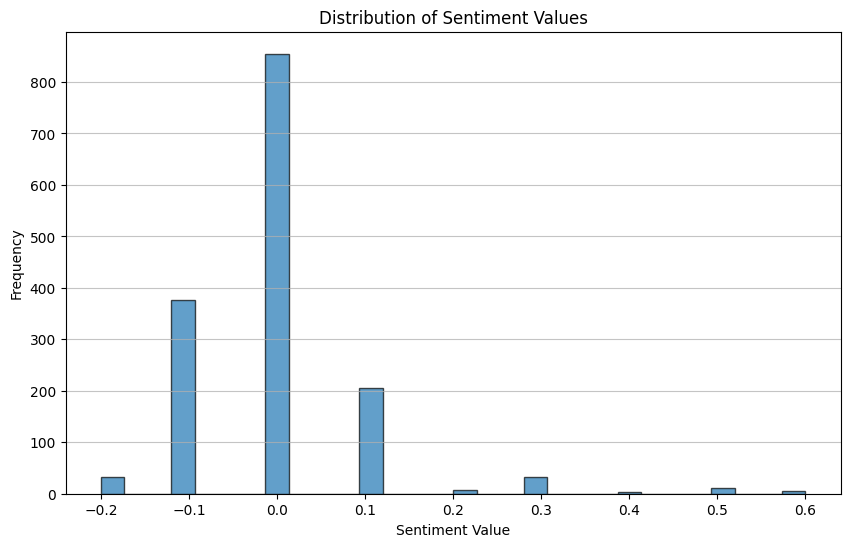

In [23]:
# Plot the histogram of the 'Sentiment value' column
plt.figure(figsize=(10, 6))
plt.hist(merged_data['Sentiment value'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Training of the classifier and visualization

### Overview

This code snippet conducts sentiment analysis on headlines employing both regression and classification techniques.

Initially, the text data, consisting of headlines, undergoes transformation into numerical features via TF-IDF vectorization. Concurrently, sentiment values linked to the headlines are amalgamated with the text features.

Subsequently, a Random Forest regressor is trained on the combined features and sentiment scores to predict sentiment values. Assessment of the regression model's performance is carried out through evaluation metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared Score.

Additionally, a Random Forest classifier is trained using the combined features and sentiment values to perform binary classification on whether the sentiment indicates a price increase or not. The classification report, including precision, recall, F1-score, and support, is generated to evaluate the classification model.

To provide a visual representation of the classification performance, both the confusion matrix and the classification report are rendered using heatmaps.

In [24]:
# Transforming headlines into numerical features with TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_text = vectorizer.fit_transform(merged_data['Headline']) 
    
# Combine text features with sentiment scores
X = np.hstack((X_text.toarray(), merged_data[['Sentiment value']].values))

# Target variable
y = merged_data['Sentiment textblob']  

# 80-20 split as standard
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest regressor
clf = RandomForestRegressor(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the report
print("RandomForestRegressor Report:")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

RandomForestRegressor Report:
Mean Absolute Error: 0.07559354540211363
Mean Squared Error: 0.016908131769143825
R-squared Score: 0.4297019017449405


In [25]:
# Convert the TF-IDF matrix to a DataFrame and rename columns
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

# Combine with sentiment values
X_combined = pd.concat([X_text_df, merged_data[['Sentiment value']].reset_index(drop=True)], axis=1)
X_combined.columns = X_combined.columns.astype(str)  # Ensure all column names are strings

# Binary target variable
y = abs(merged_data['Sentiment textblob']) > 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train a classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.73      0.92      0.81       162
        True       0.87      0.62      0.72       144

    accuracy                           0.78       306
   macro avg       0.80      0.77      0.77       306
weighted avg       0.80      0.78      0.77       306



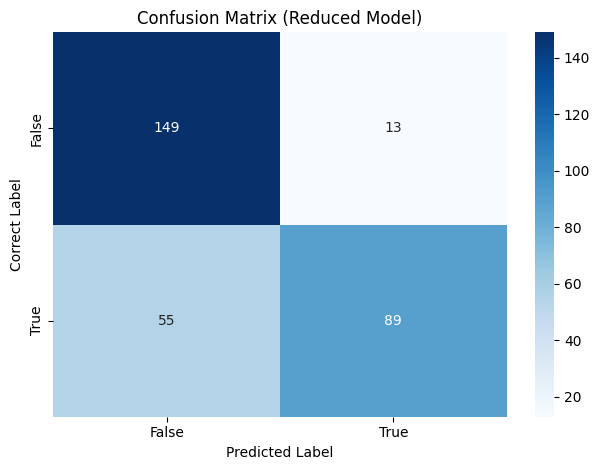

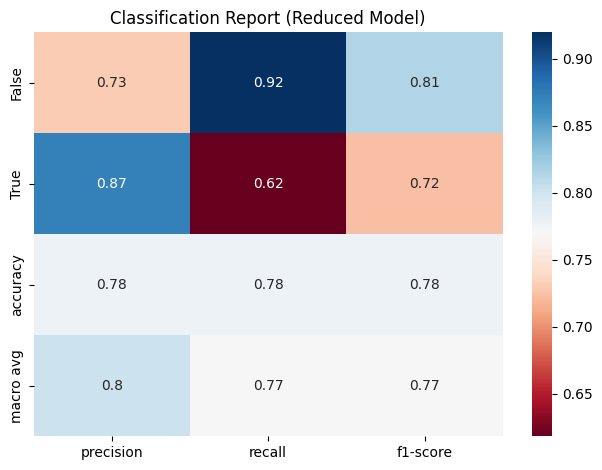

In [26]:
# Results visualization

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Correct Label')
    plt.title(title)

def plot_classification_report(y_true, y_pred, title):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="RdBu")
    plt.title(title)

plot_confusion_matrix(y_test, y_pred, "Confusion Matrix (Reduced Model)")
plt.tight_layout()
plt.show()

plot_classification_report(y_test, y_pred, "Classification Report (Reduced Model)")
plt.tight_layout()
plt.show()